In [429]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import matplotlib.image as mpimg
from PIL import Image
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as spalg
import scipy.ndimage as ndimage
from tqdm import tqdm, trange

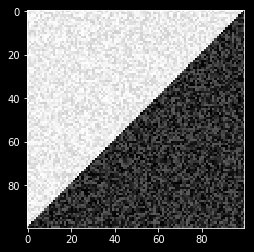

In [430]:
def step_image_BW(n=100):
    ref_img = 0.7 + 0.3 * np.random.uniform(size=(n, n))
    ref_img[np.tril_indices_from(ref_img)] -= 0.7
    ref_img = (ref_img * 255)[:, :, None].astype(int)
    return ndimage.rotate(ref_img, 90)

plt.imshow(step_image_BW()[:, :, 0], cmap="Greys_r")

In [431]:
class BilateralGrid:
    
    def __init__(self, ref_img, sigma):
        self.ref_img = ref_img
        self.sigma = sigma
        
        self.compute_everything()
        
    def compute_everything(self):
        self.compute_useful_stuff()
        self.compute_splat()
        self.compute_blur()
        
    def compute_useful_stuff(self):
        
        self.D = 2 + self.ref_img.shape[2]
        
        self.grid_shape = np.hstack([
            np.ceil(self.ref_img.shape[:2] / self.sigma[:2]) + 1,
            np.ceil(255 / self.sigma[2:]) + 1
        ]).astype(int)
        self.grid_indices = np.indices(self.grid_shape)
        
        self.n_pixels = np.prod(self.ref_img.shape[:2])
        self.n_vertices = np.prod(self.grid_shape)
        
        self.coord_to_vertex = np.arange(self.n_vertices).reshape(self.grid_shape).astype(int)

        self.vertex_to_coord = np.stack([
            self.grid_indices[dim].flatten() for dim in range(self.D)
        ], axis=1)
        
        self.x_ref_img = np.indices(self.ref_img.shape[:2])[0].flatten()
        self.y_ref_img = np.indices(self.ref_img.shape[:2])[1].flatten()
        
        self.pos_ref_img = np.hstack([
            self.x_ref_img[:, None],
            self.y_ref_img[:, None],
            self.ref_img[self.x_ref_img, self.y_ref_img]
        ])
        
    def compute_splat(self):
        
        self.pos_grid = np.rint(self.pos_ref_img / self.sigma).astype(int)
        
        self.nearest_neighbors = self.coord_to_vertex[tuple(
            self.pos_grid[:, dim]
            for dim in range(self.D)
        )]
        self.useful_vertices = np.sort(np.unique(self.nearest_neighbors))
        self.n_useful_vertices = len(self.useful_vertices)
        self.useful_vertex_to_coord = self.vertex_to_coord[self.useful_vertices]
        
        S = sparse.lil_matrix((self.n_useful_vertices, self.n_pixels), dtype=np.float)
        for uv_ind in tqdm(range(len(self.useful_vertices)), desc="Computing splat matrix"):
            uv = self.useful_vertices[uv_ind]
            nearby_pixels = np.where(self.nearest_neighbors == uv)[0]
            S[uv_ind, nearby_pixels] = 1
        self.S = S.tocsr()
        
    def compute_blur(self):
        
        B = sparse.lil_matrix((self.n_vertices, self.n_vertices), dtype=np.float)
        B[np.diag_indices_from(B)] = 6

        possible_neighbor_steps = [
            np.array([0] * dim + [1] + [0] * (self.D - dim - 1))
            for dim in range(self.D)
        ] + [
            np.array([0] * dim + [-1] + [0] * (self.D - dim - 1))
            for dim in range(self.D)
        ]

        for neighbor_step in tqdm(possible_neighbor_steps, desc="Computing blur matrix"):
            
            neighbors_coord = self.vertex_to_coord[np.arange(self.n_vertices)] + neighbor_step

            neighbors_coord_acceptable = True
            for dim, dim_size in enumerate(self.grid_shape):
                neighbors_coord_acceptable = (
                    neighbors_coord_acceptable &
                    (neighbors_coord[:, dim] >= 0) &
                    (neighbors_coord[:, dim] < dim_size)
                )

            acceptable_neighbors = self.coord_to_vertex[tuple(
                    neighbors_coord[neighbors_coord_acceptable][:, dim]
                    for dim in range(self.D)
            )]
            vertices_with_acceptable_neighbors = np.arange(self.n_vertices)[neighbors_coord_acceptable]
            B[vertices_with_acceptable_neighbors, acceptable_neighbors] = 1

        B = B[np.ix_(self.useful_vertices, self.useful_vertices)]
        self.B = B.tocsr()

In [432]:
def bistochastize(S, B, iterations=50):
    m = S.dot(np.ones(S.shape[1]))
    n = np.ones(B.shape[1])
    for it in range(iterations):
        new_n = np.sqrt((n * m) / (B.dot(n)))
        if np.linalg.norm(new_n - n) < 1e-5:
            break
        else:
            n = new_n
    Dn = sparse.csr_matrix(np.diag(n))
    Dm = sparse.csr_matrix(np.diag(m))
    return Dn, Dm

In [433]:
def prec_conj_grad(A, b, init, M_1, iterations=25):
    x = init
    r = b - A.dot(x)
    d = M_1(r)
    delta_new = r.dot(d)
    for it in range(iterations):
        q = A.dot(d)
        alpha = delta_new / d.dot(q)
        x = x + alpha * d
        r = r - alpha * q
        s = M_1(r)
        delta_old = delta_new
        delta_new = r.dot(s)
        beta = delta_new / delta_old
        d = s + beta * d
    return x

In [434]:
def bilateral_representation(V, sigma):
    D = V.shape[1]
    grid_shape = np.ceil((V.max(axis=0) / sigma) + 1).astype(int)
    
    n_abstract_pixels = len(V)
    n_vertices = np.prod(grid_shape)

    coord_to_vertex = np.arange(n_vertices).reshape(grid_shape).astype(int)

    grid_indices = np.indices(grid_shape)
    vertex_to_coord = np.stack([
        grid_indices[dim].flatten()
        for dim in range(D)
    ], axis=1)
    
    pos_grid = np.rint(V / sigma).astype(int)

    nearest_neighbors = coord_to_vertex[tuple(zip(*pos_grid))]
    useful_vertices = np.sort(np.unique(nearest_neighbors))
    n_useful_vertices = len(useful_vertices)
    
    S = sparse.lil_matrix((n_useful_vertices, n_abstract_pixels), dtype=np.float)
    
    for uv_ind in range(len(useful_vertices)):
        uv = useful_vertices[uv_ind]
        nearby_pixels = np.where(nearest_neighbors == uv)[0]
        S[uv_ind, nearby_pixels] = 1
        
    return S, vertex_to_coord[useful_vertices]

In [435]:
def build_pyramid(useful_vertex_to_coord):
    V = useful_vertex_to_coord
    S_pyr = []
    while len(V) > 1:
        Sk, V = bilateral_representation(V, 2 * np.ones(V.shape[1]))
        S_pyr.append(Sk)
    return S_pyr

def build_P(S_pyr):
    prod = sparse.eye(S_pyr[0].shape[1])
    P = prod
    for s in S_pyr:
        prod = s.dot(prod)
        P = sparse.vstack([P, prod])
    return P

In [436]:
def M_jacobi(y, A):
    return y / A.diagonal()

def M_hier(y, A, P, alpha=2, beta=5):
    z_size, y_size = P.shape
    
    P1 = P.dot(np.ones(y_size))
    Py = P.dot(y)
    PA = P.dot(A.diagonal())
    
    z_weight = 1
    
    return P.T.dot(z_weight * P1 * Py / PA)

def y_hier(S, C, T, P, alpha=4, beta=0):
    z_size, y_size = P.shape
    
    P1 = P.dot(np.ones(y_size))
    PSc = P.dot(S.dot(C))
    PSct = P.dot(S.dot(C * T))

    z_weight = 1

    y_init = (
        P.T.dot(z_weight * PSct / P1) /
        P.T.dot(z_weight * PSc / P1)
    )
    
    return y_init

In [437]:
def solve(bilateral_grid, C, T, lambd, precond_init_method="simple"):
    S, B = bilateral_grid.S, bilateral_grid.B
    Dn, Dm = bistochastize(S, B)
    
    A = lambd * (Dm - Dn.dot(B).dot(Dn)) + sparse.diags(S.dot(C))
    b = S.dot(C * T)
    c = 0.5 * (C * T).dot(T)
    
    if precond_init_method == "simple":
        y_init = S.dot(C * T) / np.clip(S.dot(C), a_min=1, a_max=None)
        def M_1(y):
            return M_jacobi(y, A)
    
    elif precond_init_method == "hierarchical":
        S_pyr = build_pyramid(bilateral_grid.useful_vertex_to_coord)
        P = build_P(S_pyr)
        y_init = y_hier(S, C, T, P)
        def M_1(y):
            return M_hier(y, A, P)
    
    y_opt = prec_conj_grad(A, b, init=y_init, M_1=M_1)
    return y_opt

In [438]:
def show_smoothing(ref_img, new_img, save=True):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    if ref_img.shape[2] == 1:
        ref_img, new_img = ref_img[:, :, 0], new_img[:, :, 0]
        cmap= "Greys_r"
    else:
        cmap = None
        
    fig, ax = plt.subplots(1, 2, figsize=(18, 9))
    ax[0].imshow(ref_img, cmap=cmap)
    ax[0].set_title("Original image")
    ax[1].imshow(new_img, cmap=cmap)
    ax[1].set_title("Smoothed image")
    plt.show()
    
    if save:
        ref_img_pil = Image.fromarray(ref_img.astype("uint8"))
        ref_img_pil.save("results/smoothing_ref.png")
        new_img_pil = Image.fromarray(new_img.astype("uint8"))
        new_img_pil.save("results/smoothing_new.png")
    

def show_colorization(ref_img, target_img, new_img, save=True):
    new_img = np.clip(new_img, a_min=0, a_max=255)
    fig, ax = plt.subplots(1, 3, figsize=(18, 9))
    ax[0].imshow(Image.fromarray(ref_img[:, :, 0], mode="L").convert("RGB"))
    ax[0].set_title("Original BW image")
    ax[1].imshow(Image.fromarray(target_img, mode="YCbCr").convert("RGB"))
    ax[1].set_title("User-marked BW image")
    ax[2].imshow(Image.fromarray(new_img, mode="YCbCr").convert("RGB"))
    ax[2].set_title("Automatically colorized image")
    plt.show()
    
    if save:
        ref_img_pil = Image.fromarray(ref_img[:, :, 0].astype("uint8"), mode="L")
        ref_img_pil.save("results/colorization_ref.png")
        target_img_pil = Image.fromarray(target_img.astype("uint8"), mode="YCbCr").convert("RGB")
        target_img_pil.save("results/colorization_target.png")
        new_img_pil = Image.fromarray(new_img.astype("uint8"), mode="YCbCr").convert("RGB")
        new_img_pil.save("results/colorization_new.png")

In [439]:
def smoothing(
    ref_img,
    lambd, sigma_xy, 
    sigma_l=None, sigma_rgb=None, sigma_alpha=None
):
    if ref_img.shape[2] == 1:
        sigma = np.array([sigma_xy, sigma_xy, sigma_l])
    elif ref_img.shape[2] == 3:
        sigma = np.array([sigma_xy, sigma_xy, sigma_rgb, sigma_rgb, sigma_rgb])
    elif ref_img.shape[2] == 4:
        sigma = np.array([sigma_xy, sigma_xy, sigma_rgb, sigma_rgb, sigma_rgb, sigma_alpha])
    
    bilateral_grid = BilateralGrid(ref_img, sigma)
    S, B = bilateral_grid.S, bilateral_grid.B
    
    target_img = ref_img
    new_img = np.empty_like(target_img)
    
    for channel in tqdm(range(target_img.shape[2]), desc="Filtering channels"): 
        T = target_img[:, :, channel].flatten()
        C = np.ones_like(T)

        y = solve(bilateral_grid, C, T, lambd)
        x = S.T.dot(y).reshape(ref_img.shape[:2])
        
        new_img[:, :, channel] = x
        
    show_smoothing(ref_img, new_img)
    
    return new_img

In [440]:
def colorization(
    ref_img, target_img,
    lambd, sigma_xy, sigma_l
):
    sigma = np.array([sigma_xy, sigma_xy, sigma_l])
    
    bilateral_grid = BilateralGrid(ref_img, sigma)
    S, B = bilateral_grid.S, bilateral_grid.B
    
    new_img = np.empty_like(target_img)
    new_img[:, :, 0] = ref_img[:, :, 0]

    for channel in tqdm(range(1, 3), desc="Filtering channels"):
        
        T = target_img[:, :, channel].flatten()
        C = np.zeros_like(T)
        C[T != np.median(T)] = 1
        
        y = solve(bilateral_grid, C, T, lambd, precond_init_method)
        x = S.T.dot(y).reshape(ref_img.shape[:2])
        
        new_img[:, :, channel] = x
        
    show_colorization(ref_img, target_img, new_img)
    
    return new_img

Filtering channels: 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]


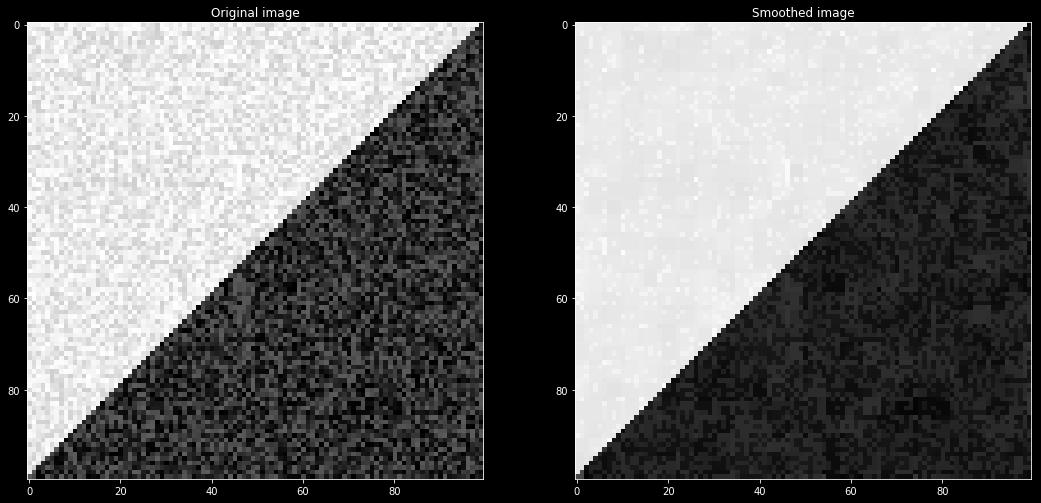

In [441]:
ref_img = step_image_BW(n=100)

new_img = smoothing(
    ref_img=ref_img,
    lambd=10, sigma_xy=2, sigma_l=70
)

Filtering channels: 100%|██████████| 3/3 [00:00<00:00, 16.33it/s]


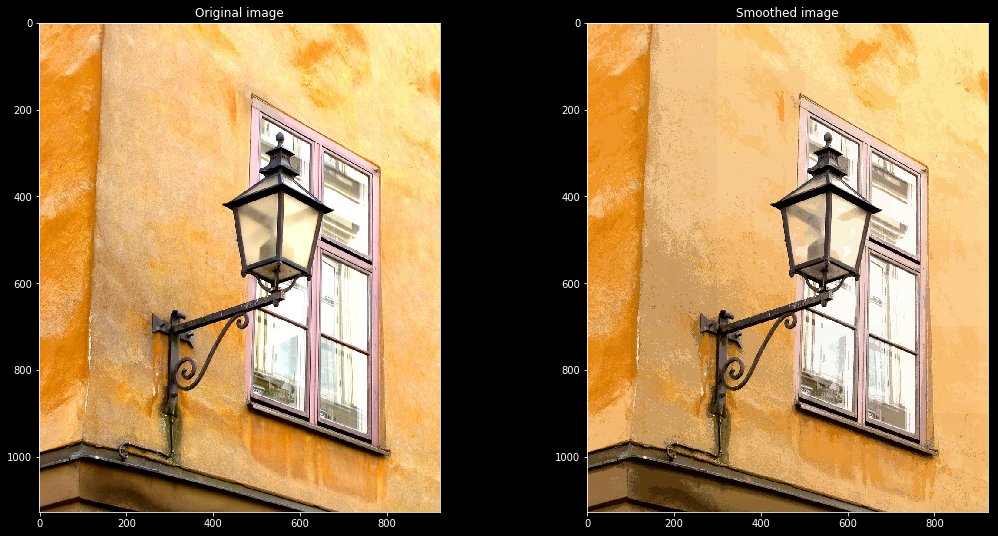

In [442]:
ref_img = (mpimg.imread("pictures/lamp.jpg")).astype(int)

new_img = smoothing(
    ref_img=ref_img,
    lambd=2, sigma_xy=200, sigma_rgb=50
)

Filtering channels: 100%|██████████| 2/2 [00:03<00:00,  1.57s/it]


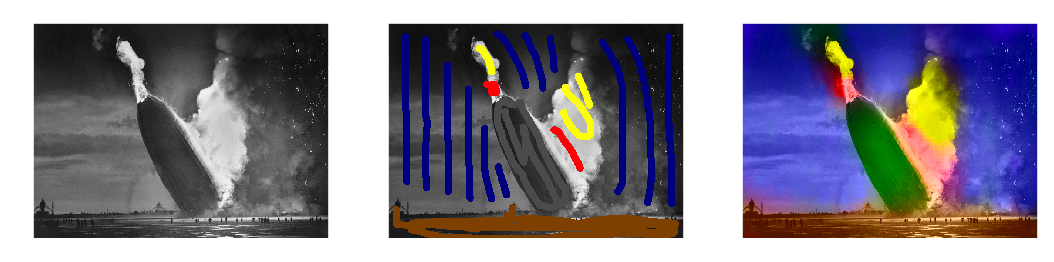

In [339]:
ref_img_BW_pil = Image.open("pictures/hindenburg_BW.jpg").convert("YCbCr")
ref_img_marked_pil = Image.open("pictures/hindenburg.jpg").convert("YCbCr")
ref_img = np.asarray(ref_img_BW_pil)[:, :, :1]
target_img = np.asarray(ref_img_marked_pil)[:, :, :]

new_img = colorization(
    ref_img=ref_img, target_img=target_img,
    lambd=1, sigma_xy=10, sigma_l=50
)

## Domain transform

In [443]:
def box_filter_naive(I, ct, sigma_H):
    r = sigma_H * np.sqrt(3)
    J = np.empty_like(I)
    
    dim = I.shape[0]
    for p in range(dim):
        J_p = 0
        K_p = 0
        for q in range(p, dim):
            if abs(ct[q] - ct[p]) > r:
                break
            J_p += I[q, :]
            K_p += 1
        for q in range(p-1, -1):
            if abs(ct[q] - ct[p]) > r:
                break
            J_p += I[q, :]
            K_p += 1 
        J[p, :] = J_p[:] / K_p
    return J

def box_filter_recursive1(I, ct, sigma_H):
    a = np.exp(-np.sqrt(2) / sigma_H)
    dim, channels = I.shape
    
    J_tmp = np.empty_like(I)
    J_tmp[0, :] = I[0, :]
    for p in range(1, dim):
        d = ct[p] - ct[p-1]
        J_tmp[p, :] = (1 - a**d) * I[p, :] + (a**d) * J_tmp[p-1, :]
    
    J = np.empty_like(I)
    J[-1, :] = J_tmp[-1, :]
    for p in range(dim-2, -1, -1):
        d = ct[p+1] - ct[p]
        J[p, :] = (1 - a**d) * J_tmp[p, :] + (a**d) * J[p+1, :]
    
    return J

def box_filter_recursive2(I, ct, sigma_H):
    a = np.exp(-np.sqrt(2) / sigma_H) 
    d = np.diff(ct)
    J = np.empty_like(I)
    
    dim, channels = I.shape
    
    A_forward = sparse.diags([1] + list(1 - a**d))
    B_forward = sparse.identity(dim) - sparse.diags(a**d, -1)
    
    A_backward = sparse.diags(list(1 - a**d) + [1])
    B_backward = sparse.identity(dim) - sparse.diags(a**d, 1)
    
    for channel in range(channels):
        J[:, channel] = spalg.spsolve(B_forward, A_forward.dot(I[:, channel]))
        J[:, channel] = spalg.spsolve(B_backward, A_backward.dot(J[:, channel]))
    
    return J

In [444]:
def smooth_cols(I, sigma_s, sigma_r, it, N_it=3):
    sigma_H = sigma_s * np.sqrt(3) * (2 ** (N_it - it)) / np.sqrt(4 ** N_it - 1)
    new_I = np.empty_like(I)
    I_prime = np.vstack([I[:1, :, :], np.diff(I, axis=0)])
    for col in trange(I.shape[1], desc="Domain transform - iteration {} - columns".format(it)):
        ct = np.cumsum(1 + (sigma_s / sigma_r) * np.abs(I_prime[:, col, :].sum(axis=1)))
        new_I_slice = box_filter_recursive2(I[:, col, :], ct, sigma_H)
        new_I[:, col, :] = new_I_slice
    return new_I

def smooth_rows(I, sigma_s, sigma_r, it, N_it=3):
    sigma_H = sigma_s * np.sqrt(3) * (2 ** (N_it - it)) / np.sqrt(4 ** N_it - 1)
    new_I = np.empty_like(I)
    I_prime = np.hstack([I[:, :1, :], np.diff(I, axis=1)])
    for row in trange(I.shape[0], desc="Domain transform - iteration {} - rows".format(it)):
        ct = np.cumsum(1 + (sigma_s / sigma_r) * np.abs(I_prime[row, :, :].sum(axis=1)))
        new_I_slice = box_filter_recursive2(I[row, :, :], ct, sigma_H)
        new_I[row, :, :] = new_I_slice
    return new_I

In [445]:
def domain_transform(I, sigma_s, sigma_r, N_it=3):
    for it in range(1, N_it+1):
        for axis in [0, 1]:
            if axis == 1:
                I = smooth_rows(I, sigma_s, sigma_r, it, N_it)
            else:
                I = smooth_cols(I, sigma_s, sigma_r, it, N_it)
    return I

Domain transform - iteration 10 - rows: 100%|██████████| 1128/1128 [00:05<00:00, 196.33it/s]


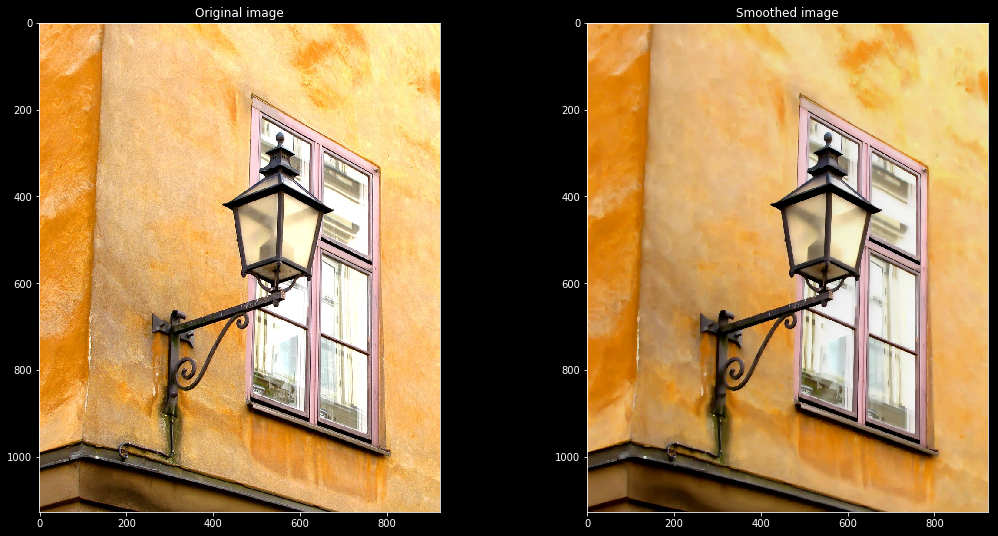

In [451]:
lamp = mpimg.imread("pictures/lamp.jpg")
#lamp = step_image_BW(100)
new_lamp = domain_transform(lamp, sigma_s=17, sigma_r=0.8*255, N_it=10)

show_smoothing(lamp, new_lamp, save=True)